In [ ]:
!pip install osmnx
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 11.2 MB 24.9 MB/s 
     |████████████████████████████████| 1.0 MB 70.0 MB/s 
     |████████████████████████████████| 1.0 MB 43.7 MB/s 
     |████████████████████████████████| 6.3 MB 51.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 16.7 MB 306 kB/s 
     |████████████████████████████████| 959 kB 48.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import osmnx as ox
import networkx as nx
import requests
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import time
import random
import math
import copy

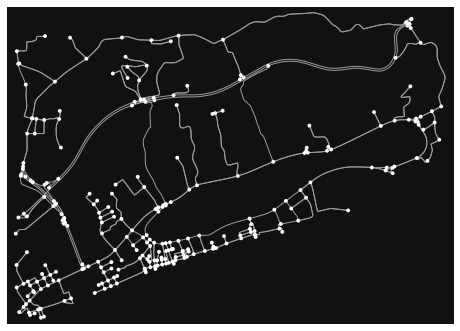

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5de7d82490>)

In [ ]:
#Ritaglio Messina
#north, west, south, east = 38.2617, 15.5929, 38.2540,15.6100
north,west,south,east = 38.2699, 15.5996, 38.2537, 15.6279 #serri
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive')  
#G = ox.graph_from_place('Messina, Italy', network_type = 'drive')  
# Plotting the map graph 
ox.plot_graph(G)


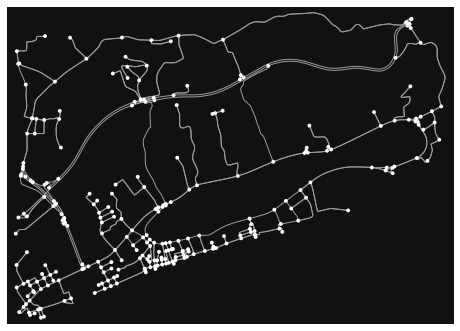

279
1.74375
2


In [ ]:
#Trasformo grafo non orientato in orientato
DG = G.to_directed()
ox.plot_graph(DG)
print(len(DG.nodes()))
n_nodes = len(G.nodes())
print(n_nodes/160)
partitions = math.ceil(len(G.nodes())/160)
print(partitions)


In [35]:
def add_elevations(G,simulate=False):
  elevations = []
  
  partitions = math.ceil(len(G.nodes())/160)
  
  if not simulate:

    inf_extreme = 0
    sup_extreme = 0
    for i in range(1,partitions+1):
      query_coords = ""
      inf_extreme = sup_extreme
      if i == partitions:
        sup_extreme = len(G.nodes())
      else:
        sup_extreme = 160*i
      #print(inf_extreme,sup_extreme)
      for node in list(G.nodes())[inf_extreme:sup_extreme]:
        query_coords += str(G.nodes[node]['y'])+','+str(G.nodes[node]['x'])+'|'
      query_coords = query_coords[:-1]
      #print(query_coords)
      x = requests.get('https://api.open-elevation.com/api/v1/lookup?locations='+query_coords)
      #print(x)

      data = x.json()
      
      #Costruisco l'array delle elevazioni
      
      for el in data['results']:
        elevations.append(el['elevation'])
  else:
    for el in G.nodes():
      elevations.append(random.randint(0,113))
  #Aggiungo elevation ai nodi
  i = 0
  for node in G.nodes(data=True):
    #print(len(elevations))
    x = node[1]
    x['el'] = elevations[i]

    i = i +1

  return elevations
  

In [ ]:
def get_length_extremes(G):
  lengths = []
  max_dist = 0
  is_init = True
  min_dist = 0
  for edge in G.edges(data=True):
    length = edge[2]['length']
    lengths.append(length)
    if is_init == True:
      min_dist = length
      is_init = False
    if(min_dist > length):
      min_dist = length
    if max_dist < length:
      max_dist = length
  
  return max_dist,min_dist,lengths


In [ ]:
max_dist,min_dist,lengths = get_length_extremes(DG)
print(max_dist,min_dist)

1195.208 1.96


In [ ]:
def get_slope_extremes(G):
  elevations = add_elevations(G)
  min_el = elevations[0]
  max_el = 0
  for el in elevations:

    if min_el > el:
      min_el = el

    if max_el < el:
      max_el = el
  return (max_el - min_el),(min_el-max_el)



In [ ]:
def perc_elevation(el_A,el_B,length):
 # print('el_A',el_A)
 # print('el_B',el_B)
 # print('length',length)
 # print()
  return ((el_B-el_A)/length)*100

In [ ]:
def add_perc_elevations(G):
   for edge in G.edges(data=True):
    node_A = edge[0]
    node_B = edge[1]
    edge[2]['perc_elevation'] = perc_elevation(DG.nodes()[node_A]['el'],DG.nodes()[node_B]['el'],edge[2]['length'])


In [36]:

max_slope,min_slope = get_slope_extremes(DG)
add_perc_elevations(DG)

print(max_slope,min_slope)
#print(max_slope,min_slope)

115 -115


In [ ]:
def norm_slope(x, lowest=min_slope, highest=max_slope):
  return (x-lowest)/(highest-lowest)
  

def norm_distance(x, lowest=min_dist, highest=max_dist):
  return (x-lowest)/(highest-lowest)

In [ ]:
def find_route(graph,origin,destination,alg='dijkstra'):
  origin_node = ox.distance.nearest_nodes(graph,*origin)
  destination_node = ox.distance.nearest_nodes(graph,*destination)
  route = nx.shortest_path(graph, origin_node, destination_node, weight = 'weight',method=alg)
  
  return route

In [ ]:
def change_weight(G,alpha):
  for edge in G.edges(data=True):
    node_A = edge[0]
    node_B = edge[1]
    edge[2]['weight'] = new_weight(edge[2]['length'],DG.nodes()[node_A]['el'],DG.nodes()[node_B]['el'],alpha)


In [ ]:
def new_weight(length,elevation_A,elevation_B,alpha=0):
  return alpha * norm_distance(length) + (1-alpha) * norm_slope(elevation_B - elevation_A)

print(DG.edges(data=True))
print(len(G.edges()))
print(len(DG.edges()))

[(310076073, 1895230177, {'osmid': 179175817, 'name': 'Via Raffaele Marino', 'highway': 'residential', 'oneway': False, 'length': 196.98499999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b310>, 'perc_elevation': 10.660710206360893}), (310076073, 1895230105, {'osmid': 367596441, 'lanes': '2', 'name': 'Via Consolare Pompea', 'highway': 'secondary', 'oneway': False, 'length': 50.623000000000005, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b250>, 'perc_elevation': 25.68002686525887}), (310076073, 537838557, {'osmid': 367596441, 'lanes': '2', 'name': 'Via Consolare Pompea', 'highway': 'secondary', 'oneway': False, 'length': 128.167, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b1d0>, 'perc_elevation': 6.241856328071969}), (310076076, 5414527784, {'osmid': 561551912, 'oneway': True, 'highway': 'secondary', 'length': 9.605, 'perc_elevation': 0.0}), (310076076, 310076078, {'osmid': 270105931, 'lanes': '2'

In [ ]:
def get_consumption(perc_elevation):
  if perc_elevation < 0:
    return 0.01*perc_elevation + 1
  else:
    return 1.08*perc_elevation + 1

In [ ]:
def add_consumptions(G):
   for edge in G.edges(data=True):
    edge[2]['perc_consumption'] = (get_consumption(edge[2]['perc_elevation']) *  edge[2]['length'])/1000


In [ ]:
def get_air_distance(pos_A,pos_B):
  #d = 2R⋅sin⁻¹(√[sin²((θ₂ - θ₁)/2) + cosθ₁⋅cosθ₂⋅sin²((φ₂ - φ₁)/2)])

  phi_1,phi_2 = pos_A[1]*(math.pi/180),pos_B[1]*(math.pi/180)
  delta_phi = (phi_2 - phi_1)
  delta_gamma  = (pos_B[0] - pos_A[0])* (math.pi/180)
  a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_gamma/2) * math.sin(delta_gamma/2)
  c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
  R = 6371e3 #earth ray in meters


  d = R * c
  return d


In [ ]:
change_weight(DG,0.3)

add_consumptions(DG)

print(DG.edges(data=True))

[(310076073, 1895230177, {'osmid': 179175817, 'name': 'Via Raffaele Marino', 'highway': 'residential', 'oneway': False, 'length': 196.98499999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b310>, 'perc_elevation': 10.660710206360893, 'weight': 0.4629451809718917, 'perc_consumption': 2.4649850000000004}), (310076073, 1895230105, {'osmid': 367596441, 'lanes': '2', 'name': 'Via Consolare Pompea', 'highway': 'secondary', 'oneway': False, 'length': 50.623000000000005, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b250>, 'perc_elevation': 25.68002686525887, 'weight': 0.40179980735080983, 'perc_consumption': 1.454623}), (310076073, 537838557, {'osmid': 367596441, 'lanes': '2', 'name': 'Via Consolare Pompea', 'highway': 'secondary', 'oneway': False, 'length': 128.167, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f5de844b1d0>, 'perc_elevation': 6.241856328071969, 'weight': 0.40607811182805975, 'perc_consumption': 0.9

In [ ]:
def node_list_to_path(G, node_list):
    """
    Given a list of nodes, return a list of lines that together
    follow the path
    defined by the list of nodes.
    Parameters
    ----------
    G : networkx multidigraph
    route : list
        the route as a list of nodes
    Returns
    -------
    lines : list of lines given as pairs ( (x_start, y_start), 
    (x_stop, y_stop) )
    """
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        # if it has a geometry attribute
        if 'geometry' in data:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute,
            # then the edge is a straight line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines


In [ ]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lat = [origin_point[1]],
        lon = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lat = [destination_point[1]],
        lon = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [ ]:
def plot_route(G,origin,destination,route):
  
  lines = node_list_to_path(DG, route)
  long2 = []
  lat2 = []
  for i in range(len(lines)):
      z = list(lines[i])
      l1 = list(list(zip(*z))[0])
      l2 = list(list(zip(*z))[1])
      for j in range(len(l1)):
          long2.append(l1[j])
          lat2.append(l2[j])
  plot_path(lat2, long2, origin, destination)

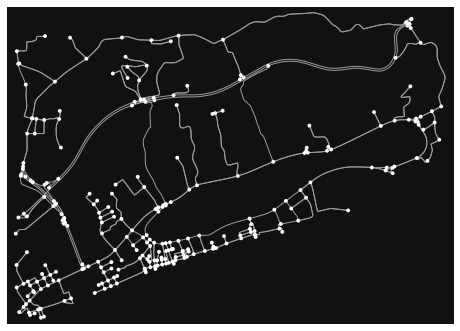

In [ ]:
#origin =  (15.60624,38.25550)
origin = (15.6006,38.2607)
#destination = ( 15.60927,38.25945)
destination = (15.60723,38.25823)
#origin = (15.5448,38.1672)

#elevations =   add_elevations(G)
#n, bins, patches = plt.hist(elevations)
#plt.show()


#n, bins, patches = plt.hist(lengths)
#plt.show()
ox.plot_graph(G)
route = find_route(DG,origin,destination)
plot_route(DG,origin,destination,route)


In [ ]:
def get_max_capacity(riders):
  max_capacity = 0
  j = 0
  for i in range(0,len(riders)):
    if max_capacity < riders[i]['battery']:
      max_capacity = riders[i]['battery']
      j = i

  return riders.pop(j)



In [ ]:
def get_distances(s,orders):
  distances = []
  for i in range(0,len(orders)):
    distances.append(get_air_distance(s,orders[i]['coords']))

  return distances

In [ ]:
def get_route_consumption(G,route):
  consumption = 0
  for i  in range(0,len(route)-1):
      consumption += G[route[i]][route[i+1]][0]['perc_consumption']
  return consumption


In [33]:
riders = [
    {
        'start': (15.6190,38.2590),
        'id': 'rider-1', #1,3
        'battery':100,
        'order_capacity':2
    },
    {
        'start': (15.6077,38.2559),
        'id': 'rider-2', #2
        'battery':100,
        'order_capacity':9
    },
    {
        'start': (15.6052,38.2677),
        'id': 'rider-3',
        'battery':100,
        'order_capacity': 12
    },
]

orders = [
      {
          'id' : 1,
          'capacity': 2,
          'coords': (15.6090,38.2595)
      },
      {
          'id' : 2,
          'capacity': 7,
          'coords':  (15.6076,38.2647)
      },
      {
          'id': 3,
          'capacity': 3,
          'coords': (15.6105,38.2569)
      }
    ]


def optimize_path(G,S,riders,orders):
  associations = {
      
  }
  riders_orders =  {
      
  }
  riders_copy = copy.deepcopy(riders)
  orders_copy = copy.deepcopy(orders)
  visited = []
  excluded_orders = []
  old_rider = None
  is_capacity_considered = True
  for r in riders_copy:
    associations[r['id']] = []
    riders_orders[r['id']] = []
  
  while orders_copy and len(visited) != len(riders):
    R = get_max_capacity(riders_copy)
    print('SELECTED RIDER',R['id'])


    if R['id'] not in visited:
      visited.append(R['id'])

    s = R['start']
    old_cons_b = 0
    old_route_b = []
    print('[riders_copy]',riders_copy)

    print('[visited]',visited)
    print('[EXCLUDED ORDERS]',excluded_orders)
    
    print('[orders_copy]',orders_copy)

    while R['battery'] > 0 and orders_copy:
      print('VISITED',visited)
      distances = get_distances(s,orders_copy) #distance in linea d'aria
      print(distances)
      print(orders_copy)
      if R['id'] not in visited:
        max_D_index = np.argmin(distances) #se è la prima iterazione prendo la più distante
        D = orders_copy.pop(max_D_index)
      else:
        min_D_index = np.argmin(distances) #altrimenti la più vicina
        D = orders_copy.pop(min_D_index)

      
      if R['order_capacity'] < D['capacity'] and is_capacity_considered:
        excluded_orders.append(D)
        continue
      
      route_f = find_route(DG,s,D['coords']) #calcolo i consumi di andata e ritorno
      cons_f = get_route_consumption(DG,route_f)
      #plot_route(G,s,D,route_f)
      route_b = find_route(DG,D['coords'],S)
      cons_b = get_route_consumption(DG,route_b)
      
      if (R['battery'] - cons_f - cons_b) > 0: #se il rider può fare entrambi i percorso
        s = D['coords'] #la prossima sorgente è diventata la vecchia destinazione
        if associations[R['id']]: #se il rider aveva qualcosa in cosa significa che devo rimuovere la destinazione
          associations[R['id']].pop()
          R['battery'] = R['battery'] + old_cons_b #e ripristinare il consumo del ritorno
          print('ripristino',R['battery'])
        
        R['battery'] = R['battery'] - cons_f - cons_b #sottraggo i consumi di andata e ritorno
        R['order_capacity'] = R['order_capacity'] - D['capacity']
        associations[R['id']].append(route_f) #aggiungo percorso andata e ritorno
        associations[R['id']].append(route_b)
        riders_orders[R['id']].append(D)
        old_route_b = route_b #memorizzo consumo e percorso del ritorno
        old_cons_b = cons_b
      else:
        #R['battery'] = 0
        
        orders_copy.append(D)
        break
    orders_copy += excluded_orders
    excluded_orders = []

    #plot_route(G,D,s,route_b)
  return associations,riders_orders

associations,r_d = optimize_path(DG,origin,riders,orders)
print(associations)
print(r_d)
#for path in associations['rider-1']:
#  plot_route(DG,(DG.nodes()[path[0]]['x'],DG.nodes()[path[0]]['y']),(DG.nodes()[path[len(path)-1]]['x'],DG.nodes()[path[len(path)-1]]['y']),path)
print(riders)

for rider,paths in associations.items():
  print(rider)
  for path in paths:
    plot_route(DG,(DG.nodes()[path[0]]['x'],DG.nodes()[path[0]]['y']),(DG.nodes()[path[len(path)-1]]['x'],DG.nodes()[path[len(path)-1]]['y']),path)


SELECTED RIDER rider-1
[riders_copy] [{'start': (15.6077, 38.2559), 'id': 'rider-2', 'battery': 100, 'order_capacity': 9}, {'start': (15.6052, 38.2677), 'id': 'rider-3', 'battery': 100, 'order_capacity': 12}]
[visited] ['rider-1']
[EXCLUDED ORDERS] []
[orders_copy] [{'id': 1, 'capacity': 2, 'coords': (15.609, 38.2595)}, {'id': 2, 'capacity': 7, 'coords': (15.6076, 38.2647)}, {'id': 3, 'capacity': 3, 'coords': (15.6105, 38.2569)}]
VISITED ['rider-1']
[874.8897757806578, 1179.993217797139, 778.0345285206331]
[{'id': 1, 'capacity': 2, 'coords': (15.609, 38.2595)}, {'id': 2, 'capacity': 7, 'coords': (15.6076, 38.2647)}, {'id': 3, 'capacity': 3, 'coords': (15.6105, 38.2569)}]
VISITED ['rider-1']
[874.8897757806578, 1179.993217797139]
[{'id': 1, 'capacity': 2, 'coords': (15.609, 38.2595)}, {'id': 2, 'capacity': 7, 'coords': (15.6076, 38.2647)}]
VISITED ['rider-1']
[590.9921326360502]
[{'id': 2, 'capacity': 7, 'coords': (15.6076, 38.2647)}]
SELECTED RIDER rider-2
[riders_copy] [{'start': (15.

rider-2


rider-3
